# IBM Quantum Challenge 2021
## [Ibrahim Almosallam](https://www.linkedin.com/in/ibrahim-almosallam/) 
[Saudi Information Technology Company (SITE)](https://site.sa), Riyadh, Saudi Arabia 

# Solution Description

This notebook will go over the solution; for details about the challenge, please refer to the [challenge notebook](https://nbviewer.org/github/qiskit-community/ibm-quantum-challenge-fall-2021/blob/main/content/challenge-4/challenge-4.ipynb)

### Quantum Fourier Transform Adder

First, we need to add two numbers together using a QFT adder. There is actually one implemented in Qiskit! So let's import it and see what's under the hood. But first, let us import necessary libraries and define some global variables.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.circuit.library.arithmetic.adders import DraperQFTAdder
from math import pi, ceil, log2

In [2]:
draw_option = 'latex' # set to 'mpl' if you would like the qiskit's view

# to display proper notations
style={ 'displaytext': {
    'Phase Return': 'e^{-i\\gamma~return(z)}',
    'Cost Calculation': 'Cost(z)',
    'Constraint Testing': 'Cost(z)\\geq~C_{max}',
    'Dephasing':'e^{-i\\alpha\\gamma~penalty(z)}',
    'Mixing Operator': 'R_{x}(2\\beta)',
    'IQFT': 'QFT^\dagger'
}}

style['displaytext']['Cost Calculation_dg'] = '\left('+style['displaytext']['Cost Calculation']+'\\right)^\\dagger'
style['displaytext']['Constraint Testing_dg'] = '\left('+style['displaytext']['Constraint Testing']+'\\right)^\\dagger'

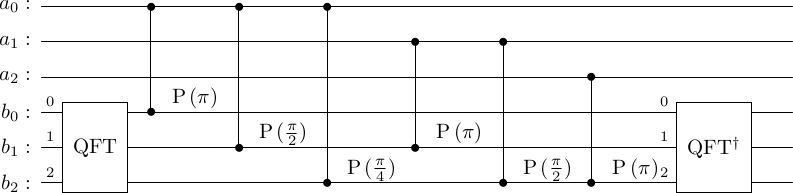

In [3]:
number = 5
a = [int(digit) for digit in bin(number)[:1:-1]]  # convert to little-endian binary notation

n_bits = len(a)

qft_adder_circuit = DraperQFTAdder(n_bits).decompose()
qft_adder_circuit.draw(draw_option, style=style)

To add $a$ to $b$, we can wire it to the $a$ wires then undo the computation after the addition. A straightforward implementation might look as follows:

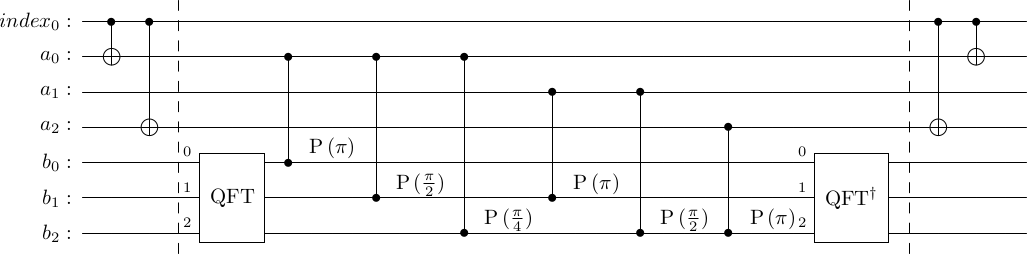

In [4]:
qa = QuantumRegister(n_bits, "a")
qb = QuantumRegister(n_bits, "b")
qi = QuantumRegister(1, "index")

adder_circuit = QuantumCircuit(qi, qa, qb, name="Adder")

# encode the number in register 'a'
ones = [i for i, bit in zip(range(n_bits), a) if bit == 1]

adder_circuit.cx(qi, qa[ones])


adder_circuit.barrier()
adder_circuit.append(qft_adder_circuit, qa[:] + qb[:])
adder_circuit.barrier()

# reset register 'a'
adder_circuit.cx(qi, qa[ones[::-1]])


adder_circuit.decompose().draw(draw_option, style=style)

We notice that some control gates are entirely useless because we know that $a_{1}$. So we modify the code to ignore those with $a_{i}=0$

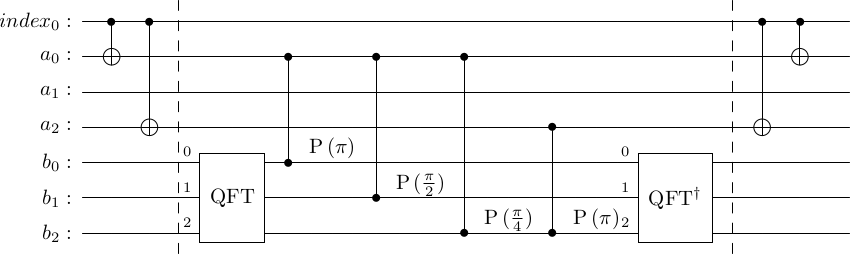

In [5]:
qft = QFT(n_bits, name="QFT", do_swaps=False)
adder_circuit = QuantumCircuit(qi, qa, qb, name="Adder")

ones = [i for i, bit in zip(range(n_bits), a) if bit == 1]  # indices of 1s

# encode the number in register 'a'
adder_circuit.cx(qi, qa[ones])


adder_circuit.barrier()
adder_circuit.append(qft, qb)

for i in ones:
    for j in range(i, n_bits):
        theta = pi / (2 ** (j - i))
        adder_circuit.cp(theta, qa[i], qb[j])


adder_circuit.append(qft.inverse(), qb)
adder_circuit.barrier()

# reset register 'a'
adder_circuit.cx(qi, qa[ones[::-1]])


adder_circuit.draw(draw_option, style=style)

We can simplify things further by mapping the register $b$ to the flag directly. Either *all* will be activated, or *none* will be activated. So we remove the encoding CNOTs and the temporary registers $a$

In [6]:
def sub_add(number: int, nb: int = None):

    a = [int(digit) for digit in bin(number)[:1:-1]]  # convert to little-endian binary notation
    ones = [i for i, bit in zip(range(n_bits), a) if bit == 1]  # indices of 1s

    na = len(a)

    if nb is None:
        nb = na

    sub_circuit = QuantumCircuit(qb, name="+"+str(number))

    for i in ones:
        for j in range(i, nb):
            theta = pi / (2 ** (j - i))
            sub_circuit.p(theta, qb[j])

    return sub_circuit

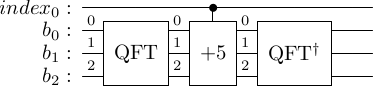

In [7]:
def add(number: int, nb: int = None, controlled: bool = True):

    if nb is None:
        nb = len(bin(number)) - 2

    qb = QuantumRegister(nb, "b")

    qft = QFT(nb, name="QFT", do_swaps=False)

    if controlled:
        qi = QuantumRegister(1, "index")
        adder_circuit = QuantumCircuit(qi, qb, name="+"+str(number))
    else:
        adder_circuit = QuantumCircuit(qb, name="+"+str(number))

    adder_circuit.append(qft, qb)

    sub_circuit = sub_add(number, nb=nb)

    if controlled:
        adder_circuit.append(sub_circuit.to_gate().control(1), qi[:] + qb[:])
    else:
        adder_circuit.append(sub_circuit.to_gate(), qb)

    adder_circuit.append(qft.inverse(), qb)

    return adder_circuit


adder_circuit = add(5, controlled=True)
adder_circuit.draw(draw_option, style=style)

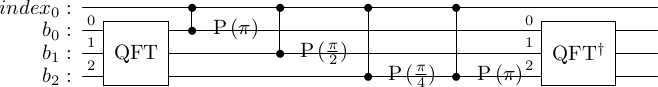

In [8]:
adder_circuit.decompose().draw(draw_option, style=style)

Notice that on some wires, multiple gates are applied to them. Let us assume at the moment that the flag is set to 1 and examine the circuit

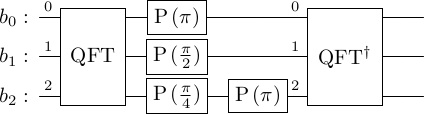

In [9]:
adder_circuit = add(5, controlled=False)
adder_circuit.decompose().draw(draw_option, style=style)

If the flag is set to 1, all of the above gates will be applied. If otherwise it is set to 0, none will be applied. Here we can exploit a property of phase gates, i.e., multiplying two gates is equivalent to adding their phases.

$P(\lambda)=\begin{pmatrix}1 & 0 \\ 0  & e^{i\lambda} \end{pmatrix} \rightarrow P(\lambda)P(\theta) = \begin{pmatrix}1 & 0 \\ 0  & e^{i\lambda} \end{pmatrix}\begin{pmatrix}1 & 0 \\ 0  & e^{i\theta} \end{pmatrix}=\begin{pmatrix}1 & 0 \\ 0  & e^{i\lambda}e^{i\theta} \end{pmatrix}=\begin{pmatrix}1 & 0 \\ 0  & e^{i(\lambda+\theta)} \end{pmatrix}=P(\lambda+\theta)$

Also we can use the fact that $e^{i\theta + 2\pi k} = e^{i\theta}$ for any integer $k$ and that $P(0)=I$. We can also use the approximation $P(\theta)\approx I$ if $\theta<\epsilon$ for a small value of $\epsilon$. If the number is not controlled by another flag, for example when adding the offset $w$, we can replace the controlled-phase gates with phase gates. Let us compact things into one function.

In [10]:
def sub_add(number: int, nb: int = None, optimized: bool = True):

    a = [int(digit) for digit in bin(number)[:1:-1]]  # convert to little-endian binary notation
    na = len(a)

    ones = [i for i, bit in zip(range(na), a) if bit == 1]  # indicies of 1s

    if nb is None:
        nb = na

    qb = QuantumRegister(nb, "b")
    sub_circuit = QuantumCircuit(qb, name="+"+str(number))

    min_angle = 0
    if optimized:
        # first we add up the angles
        thetas = [0] * nb

        for i in range(na):
            for j in range(i, nb):
                thetas[j]+= (a[i] * pi / (2 ** (j - i))) % (2 * pi)

        min_angle = 0  # this can be finetuned to also skip gates with very small angles

        # Then we apply the gates
        for j in range(nb):
            if thetas[j] > min_angle:  # or we can set a threshold so that we don't waste gates by rotating by a small angles
                sub_circuit.p(thetas[j], qb[j])
    else:
        for i in range(na):
            for j in range(i, nb):
                theta = a[i] * pi / (2 ** (j - i))
                if theta > min_angle:  # or we can set a threshold so that we don't waste gates by rotating by a small angles
                    sub_circuit.p(theta, qb[j])

    return sub_circuit


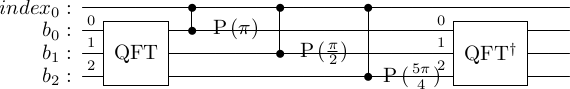

In [11]:
def add(number: int, nb: int = None, controlled: int = True):

    if nb is None:
        nb = len(bin(number)) - 2

    qb = QuantumRegister(nb, "b")

    qft = QFT(nb, name="QFT", do_swaps=False)

    if controlled:
        qi = QuantumRegister(1, "index")
        adder_circuit = QuantumCircuit(qi, qb,name='+'+str(number))
    else:
        adder_circuit = QuantumCircuit(qb, name='+'+str(number))

    adder_circuit.append(qft, qb)

    sub_circuit = sub_add(number, nb=nb, optimized=True)

    if controlled:
        adder_circuit.append(sub_circuit.to_gate().control(1), qi[:] + qb[:])
    else:
        adder_circuit.append(sub_circuit.to_gate(), qb)

    adder_circuit.append(qft.inverse(), qb)

    return adder_circuit


adder_circuit = add(5, controlled=True)
adder_circuit.decompose().draw(draw_option, style=style)

### Adding Multiple Numbers

Adding multiple numbers amounts to just repeating the circuit above for every number.

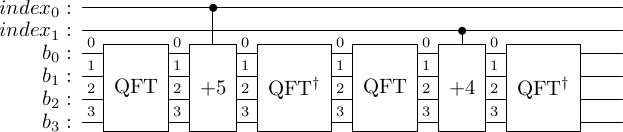

In [12]:
def add(numbers, nb=None, controlled=True, optimized=True):

    length = len(numbers)
    nb = len(bin(sum(numbers))) - 2  # the counter needs to accommodate the the maximum possible value

    qb = QuantumRegister(nb, "b")

    qft = QFT(nb, name="QFT", do_swaps=False)

    if controlled:
        qi = QuantumRegister(length, "index")
        adder_circuit = QuantumCircuit(qi, qb, name="Cost Calculation")
    else:
        adder_circuit = QuantumCircuit(qb, name="Cost Calculation")

    for i in range(length):
        adder_circuit.append(qft, qb)

        sub_circuit = sub_add(numbers[i], nb=nb, optimized=True)

        if controlled:
            adder_circuit.append(sub_circuit.to_gate().control(1), [qi[i]] + qb[:])
        else:
            adder_circuit.append(sub_circuit.to_gate(), qb)

        adder_circuit.append(qft.inverse(), qb)

    return adder_circuit


adder_circuit = add([5, 4], controlled=True, optimized=True)
adder_circuit.draw(draw_option, style=style)

Note that $QFT$ is applied straight after a $QFT^{\dagger}$, and we know that $QFT^{\dagger}QFT=I$. Thus we can ignore adding $QFT$s in the adder and just apply them once before and after applying the counter circuit.

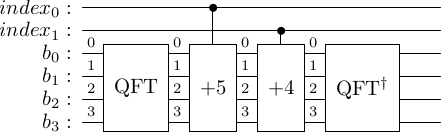

In [13]:
def add(numbers, nb=None, controlled=True, optimized=True, apply_qft=False):

    length = len(numbers)
    nb = len(bin(sum(numbers))) - 2# the counter needs to accommodate the the maximum possible value

    qb = QuantumRegister(nb, "b")

    qft = QFT(nb, name="QFT", do_swaps=False)

    if controlled:
        qi = QuantumRegister(length, "index")
        adder_circuit = QuantumCircuit(qi, qb, name="Cost Calculation")
    else:
        adder_circuit = QuantumCircuit(qb, name="Cost Calculation")

    if not apply_qft:
        adder_circuit.append(qft, qb)

    for i in range(length):
        if apply_qft:
            adder_circuit.append(qft, qb)

        sub_circuit = sub_add(numbers[i], nb=nb, optimized=True)

        if controlled:
            adder_circuit.append(sub_circuit.to_gate().control(1), [qi[i]] + qb[:])
        else:
            adder_circuit.append(sub_circuit.to_gate(), qb)

        if apply_qft:
            adder_circuit.append(qft.inverse(), qb)

    if not apply_qft:
        adder_circuit.append(qft.inverse(), qb)

    return adder_circuit


adder_circuit = add([5, 4], controlled=True, optimized=True, apply_qft=False)
adder_circuit.draw(draw_option, style=style)

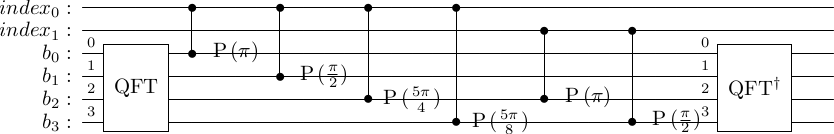

In [14]:
adder_circuit.decompose().draw(draw_option,style=style)

### Minor Enhancements

Furthermore, since the circuits will be transpiled as $CNOT$, $Rz$ and $\sqrt{X}$ gates. We can replace the phase gates with $Rz$ gates since they are equivalent up to a global phase factor.

$RZ(\lambda) = \begin{pmatrix} e^{-i\frac{\lambda}{2}} & 0 \\ 0 & e^{i\frac{\lambda}{2}} \end{pmatrix}= e^{-i\frac{\lambda}{2}}\begin{pmatrix} 1 & 0 \\ 0 & e^{i\lambda}  \end{pmatrix}= e^{-i\frac{\lambda}{2}} P(\lambda)$

During the implementation, however, the QFT at the beginning is removed. That's because, at the start, the qubits will be initialized at $\left|0\right\rangle^{\otimes n}$. It can be easily shown that $QFT\left(\left|0\right\rangle^{\otimes n}\right) = H^{\otimes n}\left|0\right\rangle^{\otimes n}$. In other words, applying $QFT$ on an all-zeros state is equivalent to applying a Hadamard gate to each qubit.

![Quantum Fourier Transform](https://upload.wikimedia.org/wikipedia/commons/6/61/Q_fourier_nqubits.png)

Image Sourec: [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform)

Note that in the case where $x_{i}=0$ $\forall i$, the state of the qubits will be:

$$\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+e^{2\pi\left[0\right]}\left|0\right\rangle\right) = \frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right) = \left|+\right\rangle$$

Thus, we can save one $QFT$ operation by initializing the sum-qubits in the $\left|+\right\rangle$ state by applying a Hadamard gate to each qubit. The $QFT^{\dagger}$ is only applied at the end, and by inverting the whole circuit during the reinitialization stage, it will apply a $QFT$ ready for the next phase.

### Data Preperation

The problem can be simplified by changing the question from "which market should I pick for each day?" to "Is the more expensive market worth the return in investment for each day?". This way, we can only focus on the difference between the two markets rather than the entire cost. For example, if for day 1 the cost for Market$_{1}$=30 and the cost for Market$_{2}$=33, we will at least pay 30 for that day. Therefore, the real question is, "is it worth paying the extra 3? This is greatly beneficial, because storing 3 requires much fewer qubits than 33.  In the case presented, Market$_{2}$ is always more expensive. Hence, the question is, "is it worth paying the extra cost for Market$_{2}$?", 1=yes, 0=no. $C_{max}$ has to be adjusted accordingly. If we think of it as a balance, we will be paying the minimum for each day. Thus, the new balance should be whatever is left over after paying the minimum for each day.

In [15]:
L1 = [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6]
L2 = [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7]
C1 = [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2]
C2 = [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4]
C_max = 33

C_max = C_max - sum(C1)  # converting maximum to maximum-difference

c = int(ceil(log2(C_max)))  # c such that 2^c >= C_max
w = (2 ** c) - C_max  # w such that w+C_max = 2^c
C_max = 2 ** c

# setting the number of qubits to store the sum such that if the last bit is 1, we have reached C_max (at least 2^c)
# I understand in some cases it might cause overflows, but in our examples they are minors and worth sacrificing
# to save qubits and gates
data_qubits = c+1
index_qubits = len(C1)

## Putting Everything Together

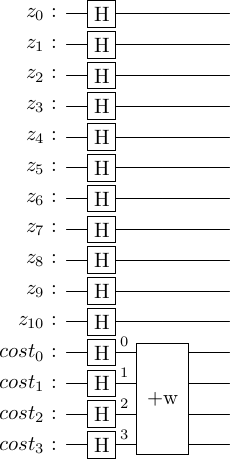

In [16]:
def initialization(index_qubits: int, data_qubits: int, w: int):

    qr_index = QuantumRegister(index_qubits, name="z")
    qr_data = QuantumRegister(data_qubits, name="cost")

    qc = QuantumCircuit(qr_index, qr_data, name="Initialization")

    qc.h(qr_index)
    qc.h(qr_data)  # using the fact that QFT on |0>^n = uniform superposition

    add_w = sub_add(w, data_qubits, False)  # we add the offset w
    add_w.name = "+w"
    qc.append(add_w, qr_data)

    return qc


qc = initialization(index_qubits, data_qubits, w)
qc.draw(draw_option, plot_barriers=False, style=style)

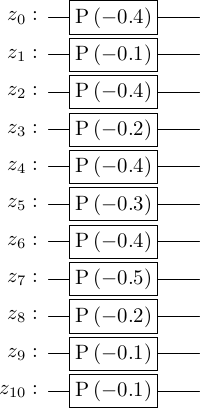

In [17]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list):

    qr_index = QuantumRegister(index_qubits, name="z")
    qc = QuantumCircuit(qr_index, name="Phase Return")

    for i in range(index_qubits):

        theta = (gamma * (L2[i] - L1[i]) / 2) % (2 * pi)

        if theta > 0:  # we can set this to a larger value to avoid small angles
            qc.p(-theta, qr_index[i])

    return qc


qc = phase_return(index_qubits, 0.2, L1, L2)
qc.draw(draw_option)

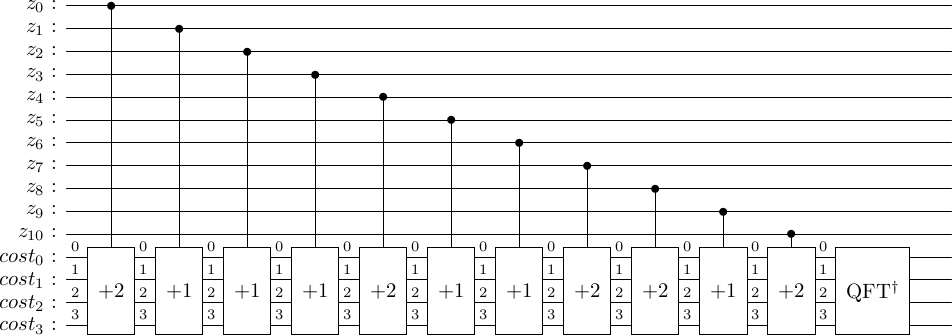

In [18]:
def sub_add(cost: int, data_qubits: int, controlled=True):

    # this function will add a cost to the data qubits (assuming QFT is applied)

    a = [int(digit) for digit in bin(cost)[:1:-1]]  # convert to little-endian binary notation

    na = len(a)  # get the length of the binary number

    qr_data = QuantumRegister(data_qubits, name="data")

    if controlled:  # we can add a number directly or controlled by another qubit
        qr_index = QuantumRegister(1, name="index")
        qc = QuantumCircuit(qr_index, qr_data, name="+"+str(cost))
    else:
        qc = QuantumCircuit(qr_data, name="+"+str(cost))

    thetas = [0] * data_qubits

    for i in range(na):
        for j in range(i, data_qubits):
            thetas[j]+= a[i] * pi / (2 ** (j - i)) # multiplying Rz gates = adding their angles

    # then just apply the sum of the angles for each target qubit
    for j in range(data_qubits):
        thetas[j] = thetas[j] % (2 * pi)  # Rz(theta+2π*k) = Rz(theta) for any integer k
        if thetas[j] > 0:  # we can set this to a larger value to avoid small angles
            if controlled:
                qc.crz(thetas[j], qr_index, qr_data[j])
            else:  # this is to add a known number , in this case, w the offset to 2^c
                qc.rz(thetas[j], qr_data[j])

    return qc


def cost_calculation(index_qubits: int, data_qubits: int, C1: list, C2: list):

    # an implementation of the QFT adder except that one of the numbers is known, not stored in a set of qubits.
    qr_index = QuantumRegister(index_qubits, name="z")
    qr_data = QuantumRegister(data_qubits, name="cost")

    qc = QuantumCircuit(qr_index, qr_data, name="Cost Calculation")

    # use the sub_add function to add each cost difference to the data register controlled by their index
    for k in range(index_qubits):
        add_delta = sub_add(C2[k] - C1[k], data_qubits, controlled=False)
        qc.append(add_delta.to_gate().control(1), [qr_index[k], *qr_data])

    # we transform back before we check the constraint
    qft = QFT(
        num_qubits=data_qubits, approximation_degree=1, do_swaps=False, name="QFT"
    )
    qc.append(qft.inverse(), qr_data)

    return qc


qc = cost_calculation(index_qubits, data_qubits, C1, C2)
qc.draw(draw_option, style=style)


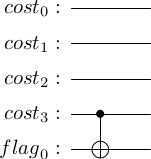

In [19]:
def constraint_testing(data_qubits: int, C_max: int):

    qr_data = QuantumRegister(data_qubits, name="cost")
    qr_f = QuantumRegister(1, name="flag")

    qc = QuantumCircuit(qr_data, qr_f, name="Constraint Testing")

    # we flip the flag if the last bit = 1
    qc.cx(qr_data[-1], qr_f)

    # no need to perform QFT, as we will invert this function later, and iQFT*QFT = I
    return qc


qc = constraint_testing(data_qubits, C_max)
qc.draw(draw_option)

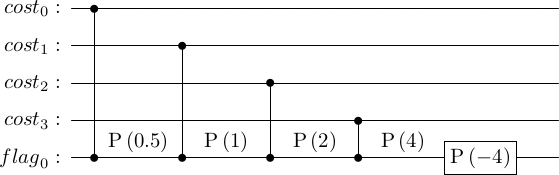

In [20]:
def penalty_dephasing(data_qubits: int, alpha: float, gamma: float):

    qr_data = QuantumRegister(data_qubits, name="cost")
    qr_f = QuantumRegister(1, name="flag")

    qc = QuantumCircuit(qr_data, qr_f, name="Dephasing")

    # Figure 13 from the paper
    for i in range(data_qubits):
        theta = ((2 ** i) * alpha * gamma) % (2 * pi)
        if theta > 0:  # we can set this to a larger value to avoid small angles
            qc.cp(theta, qr_f, qr_data[i])

    c = data_qubits - 1
    theta = ((2 ** c) * gamma * alpha) % (2 * pi)

    if theta > 0:  # we can set this to a larger value to avoid small angles
        qc.p(-theta, qr_f)

    return qc


qc = penalty_dephasing(data_qubits, 1, 0.5)
qc.draw(draw_option)

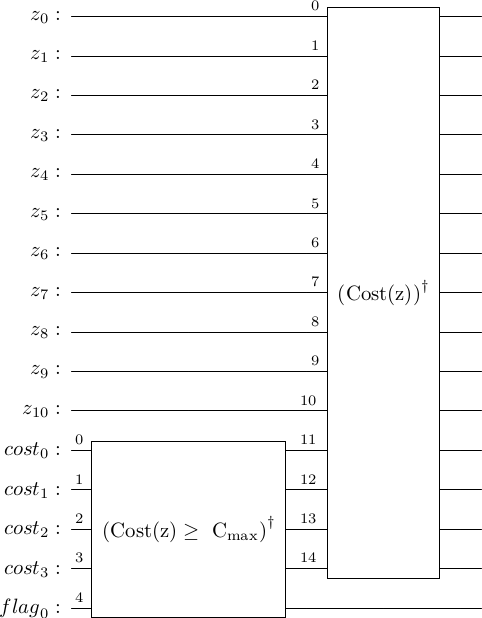

In [21]:
def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int):

    qr_index = QuantumRegister(index_qubits, name="z")
    qr_data = QuantumRegister(data_qubits, name="cost")
    qr_f = QuantumRegister(1, name="flag")

    qc = QuantumCircuit(qr_index, qr_data, qr_f, name="Reset")

    qc.append(constraint_testing(data_qubits, C_max).inverse(), qr_data[:] + qr_f[:])
    qc.barrier()
    qc.append(cost_calculation(index_qubits, data_qubits, C1, C2).inverse(), qr_index[:] + qr_data[:])

    return qc


qc = reinitialization(index_qubits, data_qubits, C1, C2, C_max)
qc.draw(draw_option, plot_barriers=False, style=style)

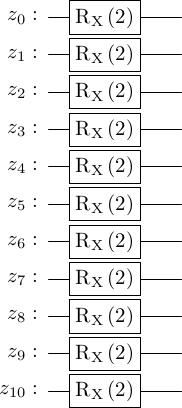

In [22]:
def mixing_operator(index_qubits: int, beta: float):

    qr_index = QuantumRegister(index_qubits, name="z")
    qc = QuantumCircuit(qr_index, name="Mixing Operator")

    # Figure 2 from the paper
    theta = 2 * beta
    if theta > 0:  # we can set this to a larger value to avoid small angles
        qc.rx(theta, qr_index)

    return qc


qc = mixing_operator(index_qubits, 1)
qc.draw(draw_option)

## Two Iterations of the Full Solver

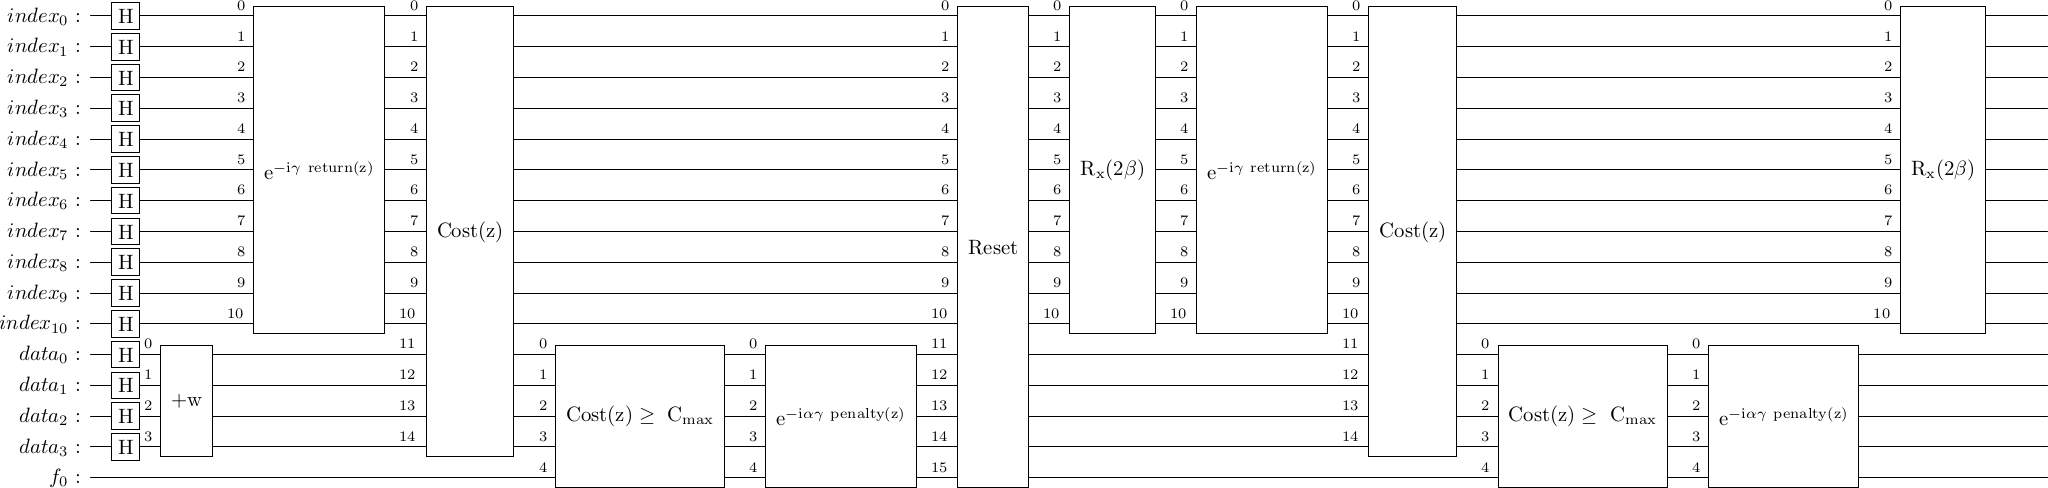

In [23]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int):

    C_max = C_max - sum(C1)  # converting maximum to maximum-difference

    c = int(ceil(log2(C_max)))  # c such that 2^c >= C_max
    w = (2 ** c) - C_max  # we want w such that w+C_max = 2^c
    C_max = 2 ** c

    # setting the number of qubits to store the sum such that if the last bit is 1, we have reached C_max (at least 2^c)
    # I understand in some cases it might cause overflows, but in our examples they are minors and worth sacrificing to save qubits and gates
    data_qubits = c+1
    index_qubits = len(C1)

    qr_index = QuantumRegister(index_qubits, name="index")
    qr_data = QuantumRegister(data_qubits, name="data")
    qr_f = QuantumRegister(1, name="f")

    qc = QuantumCircuit(qr_index, qr_data, qr_f, name="Solver")

    qc.h(qr_index)
    qc.h(qr_data)  # using the fact that QFT on |0>^n = uniform superposition

    add_w = sub_add(w, data_qubits, False)  # we add the offset w
    add_w.name = "+w"
    qc.append(add_w, qr_data)
    qc.barrier()

    ### DO NOT CHANGE THE CODE BELOW
    p = 2
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        qc.barrier()
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        qc.barrier()
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        qc.barrier()
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        qc.barrier()
        
        ### step 4: reinitialization ###
        if(gamma<1): # we can ignore resting the data registers in the last iteratiion before measurements 
            qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
            qc.barrier()
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)
        qc.barrier()
    
    return qc

L1 = [3, 7, 3, 4, 2, 6, 2, 2, 4, 6, 6]
L2 = [7, 8, 7, 6, 6, 9, 6, 7, 6, 7, 7]
C1 = [2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2]
C2 = [4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4]
C_max = 33

qc = solver_function(L1, L2, C1, C2, C_max)

qc.draw(draw_option, plot_barriers=False, fold=-1, style=style)

# Submission

The following essentially is the same, but in the format required for submission by the challenge organizers

In [24]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.compiler import transpile
from math import pi, ceil, log2

qiskit_optimize = False

# a wrapper function to optimize the circuit while adhering to the rules
def function_wrapper(fn):
    def wrapped_solevr_function(*args, **kwargs):
        qc = fn(*args, **kwargs)
        if qiskit_optimize:

            qc = transpile(
                qc,
                basis_gates=["cx", "rz", "rx", "h", "p"],
                seed_transpiler=42,
                optimization_level=3,
                approximation_degree=0.65,
            )

            qc = transpile(
                qc, basis_gates=["cx", "u3"],
                seed_transpiler=42,
                optimization_level=3,
            )

        return qc

    return wrapped_solevr_function


@function_wrapper
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int):
    def phase_return(index_qubits: int, gamma: float, L1: list, L2: list):

        qr_index = QuantumRegister(index_qubits, name="index")
        qc = QuantumCircuit(qr_index, name="Phase Return")

        for i in range(index_qubits):

            theta = (gamma * (L2[i] - L1[i]) / 2) % (2 * pi)

            if theta > 0.75:  # just trying to only apply gates when we have to (found through manual binary search)
                qc.p(-theta, qr_index[i])  # rz performed much better and produced identical results

        return qc

    def sub_add(cost: int, data_qubits: int, controlled=True):

        # this function will add a cost to the data qubits (assuming QFT is applied)

        a = [int(digit) for digit in bin(cost)[:1:-1]]  # convert to little-endian binary notation
        na = len(a)  # get the length of the binary number

        qr_data = QuantumRegister(data_qubits, name="data")

        if controlled:  # we can add a number directly or controlled by another qubit
            qr_index = QuantumRegister(1, name="index")
            qc = QuantumCircuit(qr_index, qr_data, name="+"+str(cost))
        else:
            qc = QuantumCircuit(qr_data, name="+"+str(cost))

        thetas = [0] * data_qubits

        for i in range(na):
            for j in range(i, data_qubits):
                thetas[j]+= a[i] * pi / (2 ** (j - i)) # multiplying Rz gates = adding their angles

        # then just apply the sum of the angles for each target qubit
        for j in range(data_qubits):
            thetas[j] = thetas[j] % (2 * pi)  # Rz(theta+2π*k) = Rz(theta) for any integer k
            if thetas[j] > 0.35:  # ideally this should be >0, but skipping small angles increased the performance a bit without much quality degradation
                if controlled:
                    qc.crz(thetas[j], qr_index, qr_data[j])
                else:  # this is to add a known number , in this case, w the offset to 2^c
                    qc.rz(thetas[j], qr_data[j])

        return qc

    def cost_calculation(index_qubits: int, data_qubits: int, C1: list, C2: list):

        # this is an implementation of the QFT adder except that one of the numbers is known, not stored in a set of qubits.
        qr_index = QuantumRegister(index_qubits, name="index")
        qr_data = QuantumRegister(data_qubits, name="data")

        qc = QuantumCircuit(qr_index, qr_data, name="Cost Calculation")

        # use the sub_add function to add each cost difference to the data register controlled by their index
        for k in range(index_qubits):
            add_delta = sub_add(C2[k] - C1[k], data_qubits, True)
            qc.append(add_delta, [qr_index[k], *qr_data])

        # we transform back before we check the constraint
        iqft = QFT(
            num_qubits=data_qubits,
            approximation_degree=1,
            do_swaps=False,
            inverse=True,
            insert_barriers=False,
            name="iqft",
        )
        qc.append(iqft, qr_data)

        return qc

    def constraint_testing(data_qubits: int, C_max: int):

        qr_data = QuantumRegister(data_qubits, name="data")
        qr_f = QuantumRegister(1, name="f")

        qc = QuantumCircuit(qr_data, qr_f, name="Constraint Testing")

        # we flip the flag if the last bit = 1
        qc.cx(qr_data[-1], qr_f)

        # no need to perform QFT, as we will invert this function later, and iQFT*QFT = I

        return qc

    def penalty_dephasing(data_qubits: int, alpha: float, gamma: float):

        qr_data = QuantumRegister(data_qubits, name="data")
        qr_f = QuantumRegister(1, name="f")

        qc = QuantumCircuit(qr_data, qr_f, name="Penalty Dephasing")

        # Figure 13 from the paper
        for i in range(data_qubits):
            theta = ((2 ** i) * alpha * gamma) % (2 * pi)
            if theta > 0.55:  # trying to apply gates when I have to (found through manual binary search)
                qc.cp(theta, qr_f, qr_data[i])

        c = data_qubits - 1
        theta = ((2 ** c) * gamma * alpha) % (2 * pi)

        if theta > 1.5:  # trying to apply gates when I have to (found through manual binary search)
            qc.p(-theta, qr_f)

        return qc

    def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int):

        qr_index = QuantumRegister(index_qubits, name="index")
        qr_data = QuantumRegister(data_qubits, name="data")
        qr_f = QuantumRegister(1, name="f")

        qc = QuantumCircuit(qr_index, qr_data, qr_f, name="Reinitialization")

        if gamma < 1:  # if we are in the final stage, no need to reset the data qubits
            qc.append(constraint_testing(data_qubits, C_max).inverse(), qr_data[:] + qr_f[:])
            qc.append(cost_calculation(index_qubits, data_qubits, C1, C2).inverse(), qr_index[:] + qr_data[:])

        return qc

    def mixing_operator(index_qubits: int, beta: float):

        qr_index = QuantumRegister(index_qubits, name="index")
        qc = QuantumCircuit(qr_index, name="Mixing Operator")

        # Figure 2 from the paper
        theta = 2 * beta
        if theta > 0.35:  # trying to apply gates when I have to (found through manual binary search)
            qc.rx(theta, qr_index)

        return qc

    C_max = C_max - sum(C1)  # converting maximum to maximum-difference

    c = int(ceil(log2(C_max)))  # c such that 2^c >= C_max
    w = (2 ** c) - C_max  # we want w such that w+C_max = 2^c
    C_max = 2 ** c

    # setting the number of qubits to store the sum such that if the last bit is 1, we have reached C_max (at least 2^c)
    # I understand in some cases it might cause overflows, but in our examples they are minors and worth sacrificing to save qubits and gates
    data_qubits = c+1
    index_qubits = len(C1)

    qr_index = QuantumRegister(index_qubits, name="index")
    qr_data = QuantumRegister(data_qubits, name="data")
    qr_f = QuantumRegister(1, name="f")

    cr_index = ClassicalRegister(index_qubits, name="output")

    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index, name="Solver")

    qc.h(qr_index)
    qc.h(qr_data)  # using the fact that QFT on |0>^n = uniform superposition

    add_w = sub_add(w, data_qubits, False)  # we add the offset w
    qc.append(add_w, qr_data)

    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])
    
    return qc

In [25]:
from qc_grader.grade import grade_job
from qc_grader import prepare_ex4c

job = prepare_ex4c(solver_function)
job.wait_for_final_state()

grade_job(job, '4c')

Running "wrapped_solevr_function" (1/8)... 
Running "wrapped_solevr_function" (2/8)... 
Running "wrapped_solevr_function" (3/8)... 
Running "wrapped_solevr_function" (4/8)... 
Running "wrapped_solevr_function" (5/8)... 
Running "wrapped_solevr_function" (6/8)... 
Running "wrapped_solevr_function" (7/8)... 
Running "wrapped_solevr_function" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 61a50794313f810100c3ace5) status and proceed to grading when it successfully completes.
Grading your answer for 4c. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 194712.


(True, 194712)

## With QISKIT Optimization

In [26]:
qiskit_optimize = True

job = prepare_ex4c(solver_function)
job.wait_for_final_state()

grade_job(job, '4c')

Running "wrapped_solevr_function" (1/8)... 
Running "wrapped_solevr_function" (2/8)... 
Running "wrapped_solevr_function" (3/8)... 
Running "wrapped_solevr_function" (4/8)... 
Running "wrapped_solevr_function" (5/8)... 
Running "wrapped_solevr_function" (6/8)... 
Running "wrapped_solevr_function" (7/8)... 
Running "wrapped_solevr_function" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 61a50809fd929e198cd1792d) status and proceed to grading when it successfully completes.
Grading your answer for 4c. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 163593.


(True, 163593)

# Appendix

In the bellow are some afterthought after the challenge has ended, I hope you find it useful.

In [27]:
from qiskit import Aer, execute
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

### Relation to QISKIT's Circuit Optimization
The above improvement tactic is common amongst the top participants. If you have a deeper understanding of how quantum circuits work, you will spot this and remove the redundancy. Or you can just use qiskit's automatic optimization tool! In the bellow, I will show that this what would happen if you just apply transpiling with optimization. Let us first look at the cost of the above circuit without optimization.

In [28]:
def add(number: int, nb: int = None, controlled: bool = True, optimized: bool = True, apply_qft: bool = False):

    a = [int(digit) for digit in bin(number)[:1:-1]]  # convert to little-endian binary notation
    ones = [i for i, bit in zip(range(len(a)), a) if bit == 1]  # indicies of 1s

    na = len(a)

    if nb is None:
        nb = na

    qi = QuantumRegister(1, "index")
    qb = QuantumRegister(nb, "b")

    adder_circuit = QuantumCircuit(name="+"+str(number))

    if controlled:
        adder_circuit.add_register(qi)

    adder_circuit.add_register(qb)

    if apply_qft:
        qft = QFT(nb, name="QFT", do_swaps=False)
        adder_circuit.append(qft, qb)

    if optimized:
        # first we add up the angles
        thetas = [0] * nb

        for i in range(na):
            for j in range(i, nb):
                thetas[j]+= (a[i] * pi / (2 ** (j - i))) % (2 * pi)

        min_angle = 0  # this can be finetuned to also skip gates with very small angles

        # Then we apply the gates
        for j in range(nb):
            if (
                thetas[j] > min_angle
            ):  # or we can set a threshold so that we don't waste gates by rotating by a small angles
                if controlled:
                    adder_circuit.cp(thetas[j], qi, qb[j])
                else:
                    adder_circuit.p(thetas[j], qb[j])
    else:
        for i in ones:
            for j in range(i, nb):
                theta = pi / (2 ** (j - i))
                if controlled:
                    adder_circuit.cp(theta, qi, qb[j])
                else:
                    adder_circuit.p(theta, qb[j])

    if apply_qft:
        adder_circuit.append(qft.inverse(), qb)

    return adder_circuit


In [29]:
def counter(numbers, optimized=True, apply_qft=False, controlled=True):

    length = len(numbers)
    nb = len(bin(sum(numbers))) - 2  # the counter needs to accommodate the the maximum possible value

    if controlled:
        qi = QuantumRegister(length, "index")
    else:
        qi = []

    qb = QuantumRegister(nb, "b")

    counter_circuit = QuantumCircuit(qi, qb)

    if not apply_qft:
        qft = QFT(nb, name="QFT", do_swaps=False)
        counter_circuit.append(qft, qb)

    for i in range(length):
        adder_circuit = add(
            numbers[i],
            nb=nb,
            optimized=optimized,
            apply_qft=apply_qft,
            controlled=controlled,
        )
        if controlled:
            counter_circuit.append(adder_circuit, [qi[i], *qb])
        else:
            counter_circuit.append(adder_circuit, qb)

    if not apply_qft:
        counter_circuit.append(qft.inverse(), qb)

    return counter_circuit

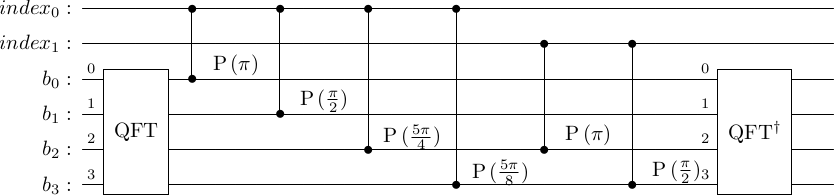

In [30]:
numbers = [5,4]

counter_circuit = counter(numbers)
counter_circuit.decompose().draw(draw_option,style=style)

In [31]:
counter_circuit = transpile(counter_circuit, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=0)

ops = counter_circuit.count_ops()
u3Ops = ops['u3']
cxOps = ops['cx']

print('u3: ', u3Ops)
print('cx: ', cxOps)
print('score: ', 10*cxOps+u3Ops)

u3:  62
cx:  36
score:  422


Now let us construct the old circuit without merging the controlled-phase gates and removing the canceled-out QFTs, and check how much it costs.

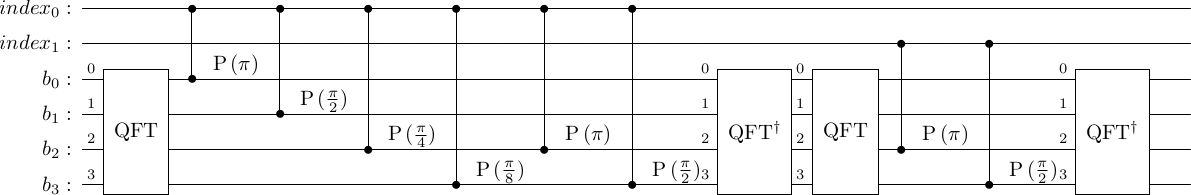

In [32]:
counter_circuit = counter(numbers, optimized=False, apply_qft=True)
counter_circuit.decompose().draw(draw_option, style=style)

In [33]:
counter_circuit = transpile(counter_circuit, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=0)

ops = counter_circuit.count_ops()
u3Ops = ops['u3']
cxOps = ops['cx']

print('u3: ', u3Ops)
print('cx: ', cxOps)
print('score: ', 10*cxOps+u3Ops)

u3:  112
cx:  64
score:  752


Now let us optimize it using qiskit

In [34]:
counter_circuit = transpile(counter_circuit, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=3)

ops = counter_circuit.count_ops()
u3Ops = ops['u3']
cxOps = ops['cx']

print('u3: ', u3Ops)
print('cx: ', cxOps)
print('score: ', 10*cxOps+u3Ops)

u3:  52
cx:  37
score:  422


Note that the score of redundency+optimization = no redundency.

### Substraction and Integer Comparision using QFT Adder
Let us just add 5 to a zero register:

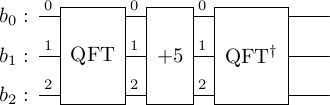

In [35]:
number = 5
nb = len(bin(number)) - 2
qb = QuantumRegister(nb, name="b")
qft = QFT(nb, name="QFT", inverse=False, do_swaps=False)
sub_add = add(number, nb=nb, controlled=False, optimized=True, apply_qft=False)

circuit = QuantumCircuit(qb)

circuit.append(qft, qb)
circuit.append(sub_add, qb)
circuit.append(qft.inverse(), qb)
circuit.draw(draw_option, style=style)

Say you want to subtract 5, you would need to ad a unitary between the $QFT$s such that the whole circuit is reduced to $I$. As a result, $\left|b_{0}\right\rangle\left|b_{1}\right\rangle\left|b_{2}\right\rangle$ will be reset to $\left|0\right\rangle\left|0\right\rangle\left|0\right\rangle$. We know the unitary just for that, it is $+5^\dagger$. Therefore, $+5^\dagger=-5$. Let us add it in, and examine the circuit.

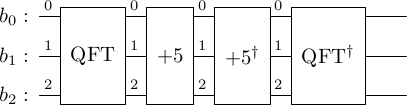

In [36]:
circuit = QuantumCircuit(qb)

circuit.append(qft, qb)
circuit.append(sub_add, qb)
circuit.append(sub_add.inverse(), qb)
circuit.append(qft.inverse(), qb)

style["displaytext"]["+5_dg"] = "+5^\dagger"

circuit.draw(draw_option, style=style)

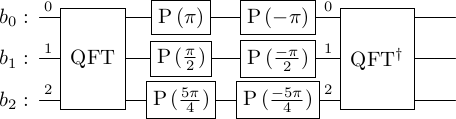

In [37]:
from qiskit.tools.visualization import circuit_drawer

circuit.decompose().draw(draw_option, style=style)

Of course, it amounts to just adding the negative phase. So let us update the function accordingly.

In [38]:
def add(number, nb=None, controlled=True, optimized=True, apply_qft=False):

    sign = 1
    symbol = "+"

    if number < 0:
        sign = -1
        symbol = "-"
        number = -number

    a = [int(digit) for digit in bin(number)[:1:-1]]  # convert to little-endian binary notation
    na = len(a)
    
    ones = [i for i, bit in zip(range(na), a) if bit == 1]  # indices of 1s


    if nb is None:
        nb = na

    qi = QuantumRegister(1, "index")
    qb = QuantumRegister(nb, "b")

    adder_circuit = QuantumCircuit(name=symbol+str(number))

    if controlled:
        adder_circuit.add_register(qi)

    adder_circuit.add_register(qb)

    if apply_qft:
        qft = QFT(nb, name="QFT", do_swaps=False)
        adder_circuit.append(qft, qb)

    if optimized:
        # first we add up the angles
        thetas = [0] * nb

        for i in range(na):
            for j in range(i, nb):
                thetas[j]+= sign * (a[i] * pi / (2 ** (j - i))) % (2 * pi)

        min_angle = 0  # this can be finetuned to also skip gates with very small angles

        # Then we apply the gates
        for j in range(nb):
            if thetas[j] > min_angle:  # or we can set a threshold so that we don't waste gates by rotating by a small angles
                if controlled:
                    adder_circuit.cp(thetas[j], qi, qb[j])
                else:
                    adder_circuit.p(thetas[j], qb[j])
    else:
        for i in ones:
            for j in range(i, nb):
                theta = sign * pi / (2 ** (j - i))
                if controlled:
                    adder_circuit.cp(theta, qi, qb[j])
                else:
                    adder_circuit.p(theta, qb[j])

    if apply_qft:
        adder_circuit.append(qft.inverse(), qb)

    return adder_circuit


Now let us just subtract, for example, 3 from 0 and look at the results

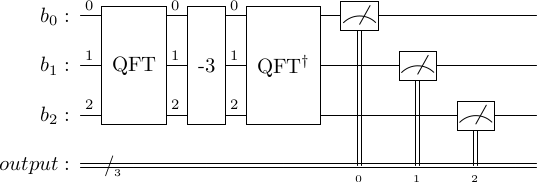

In [39]:
sub_add = add(-3, nb=nb, controlled=False, optimized=True, apply_qft=False)
cr = ClassicalRegister(nb, name="output")

circuit = QuantumCircuit(qb, cr)

circuit.append(qft, qb)
circuit.append(sub_add, qb)
circuit.append(qft.inverse(), qb)
circuit.measure(qb, cr)
circuit.draw(draw_option, style=style)

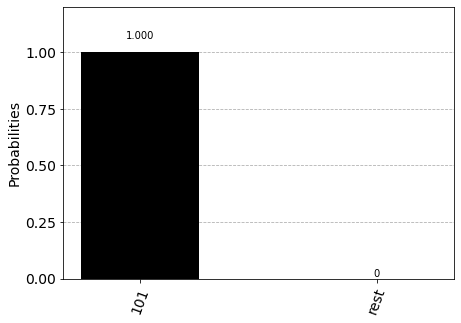

In [40]:
backend = Aer.get_backend("statevector_simulator")
results = backend.run(transpile(circuit, backend)).result()
plot_histogram(results.get_counts(), color="black" if draw_option == "latex" else None, number_to_keep=2)

The answer is 101, which turns out to be just the 2's complement of the number 3. Therefore, to determain if $a>b$, we can compute $c=b-a$ and examine the most significant bit. $a>b$ if, and only if, the MSB of $c$ is equal to $1$

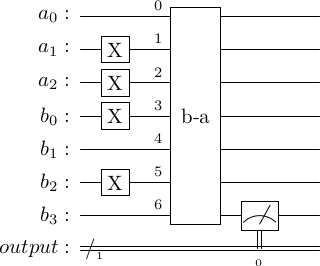

In [41]:
def greaterThan(na: int, nb: int):

    nb = max(na, nb)+1

    qa = QuantumRegister(na, "a")
    qb = QuantumRegister(nb, "b")

    qft = QFT(nb, name="QFT", do_swaps=False)

    compare_circuit = QuantumCircuit(qa, qb, name="b-a")

    compare_circuit.append(qft, qb)

    for i in range(na):
        for j in range(i, nb):
            theta = -pi / (2 ** (j - i))
            compare_circuit.cp(theta, qa[i], qb[j])
        compare_circuit.barrier()

    compare_circuit.append(qft.inverse(), qb)

    return compare_circuit


a = 6
b = 5

a = [int(digit) for digit in bin(a)[:1:-1]]  # convert to little-endian binary notation
a_ones = [i for i, bit in zip(range(len(a)), a) if bit == 1]  # indices of 1s

b = [int(digit) for digit in bin(b)[:1:-1]]  # convert to little-endian binary notation
b_ones = [i for i, bit in zip(range(len(b)), b) if bit == 1]  # indices of 1s

na = len(a)
nb = max(na, len(b))+1

qa = QuantumRegister(na, "a")
qb = QuantumRegister(nb, "b")

cr = ClassicalRegister(1, "output")
qft = QFT(nb, name="QFT", do_swaps=False)

compare_circuit = QuantumCircuit(qa, qb, cr, name="GreaterThan")

# encode a
compare_circuit.x(qa[a_ones])


# encode b
compare_circuit.x(qb[b_ones])

compare_circuit.barrier()

compare_circuit.append(greaterThan(len(qa), len(qb) - 1), qa[:] + qb[:])

compare_circuit.measure(qb[-1], cr)

compare_circuit.draw(draw_option, plot_barriers=False)

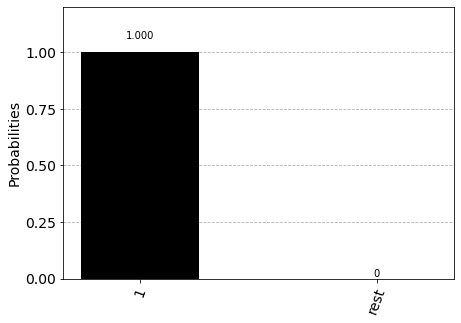

In [42]:
results = backend.run(transpile(compare_circuit, backend)).result()
plot_histogram(results.get_counts(), color="black" if draw_option == "latex" else None, number_to_keep=2)